# Power analysis

In [1]:
import os

import numpy as np
import pandas as pd
from snakemake.utils import Paramspace

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

## Read dataframe with simulation parameters

In [2]:
params = pd.read_csv('../params.csv')
params['outfile'] = [p + '.txt' for p in Paramspace(params).instance_patterns]

Filter calibration experiments:

In [3]:
params = (params
    .query('n_snps == 1')
    .reset_index(drop=True))

In [4]:
for i in params.index:
    if not os.path.exists('../results/simulations/' + params.loc[i, 'outfile']):
        print('Warning: %s not found' % params.loc[i, 'outfile'])
        params.drop(i, inplace=True)
params = params.reset_index(drop=True)

In [5]:
params

,n_cells,model,likelihood,v0,n_causal_g,n_causal_shared,n_causal_gxe,r0,n_snps,n_genes,n_individuals,cells_per_individual,n_env_gxe,n_env_tested,seed,outfile
0,50,structlmm2,gaussian,0.03,1,1,1,0.0,1,150,50,fixed,20,20,19350,n_cells~50/model~structlmm2/likelihood~gaussia...
1,50,structlmm2,gaussian,0.03,1,1,1,0.0,1,150,50,fixed,20,20,44900,n_cells~50/model~structlmm2/likelihood~gaussia...
2,50,structlmm2,gaussian,0.03,1,1,1,0.0,1,150,50,fixed,20,20,45461,n_cells~50/model~structlmm2/likelihood~gaussia...
3,50,structlmm2,gaussian,0.03,1,1,1,0.0,1,150,50,fixed,20,20,32306,n_cells~50/model~structlmm2/likelihood~gaussia...
4,50,structlmm2,gaussian,0.03,1,1,1,0.0,1,150,50,fixed,20,20,619,n_cells~50/model~structlmm2/likelihood~gaussia...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,50,structlmm2_fixed,negbin,0.15,1,1,1,0.5,1,150,50,variable,20,15,44900,n_cells~50/model~structlmm2_fixed/likelihood~n...
620,50,structlmm2_fixed,negbin,0.15,1,1,1,0.5,1,150,50,variable,20,15,45461,n_cells~50/model~structlmm2_fixed/likelihood~n...
621,50,structlmm2_fixed,negbin,0.15,1,1,1,0.5,1,150,50,variable,20,15,32306,n_cells~50/model~structlmm2_fixed/likelihood~n...
622,50,structlmm2_fixed,negbin,0.15,1,1,1,0.5,1,150,50,variable,20,15,619,n_cells~50/model~structlmm2_fixed/likelihood~n...


## Plot true positives

A gene is called a true positive, if all GxE effects were significant at $FWER < \alpha=0.05$ (family-wise error rate). The FWER is computed by assuming 25 SNPs were tested for each gene.

In [6]:
def compute_tpr(pvals, gxe_causals, threshold=0.05, n_tested=100):
    """"True positive rate across all tested SNPs."""
    if len(gxe_causals) == 0:
        return 1
    return (pvals[:, gxe_causals] < threshold / n_tested).mean()

In [7]:
for i in params.index:
    fname = '../results/simulations/' + params.loc[i, 'outfile']
    if os.path.exists(fname):
        pvals = pd.read_csv(fname, header=None).to_numpy()
        causals = [0], [0]
        try:
            params.loc[i, 'TPR'] = compute_tpr(pvals, causals)
        except:
            pass

In [8]:
model_colors = {
    'structlmm': sns.color_palette('colorblind')[2],
    'structlmm2': sns.color_palette('colorblind')[0],
    'structlmm2_fixed': sns.color_palette('colorblind')[9]
}

plt.rcParams.update({
    'font.size': 8,
})

In [9]:
cells_per_individual = ['fixed', 'variable']
likelihood = ['gaussian', 'negbin']

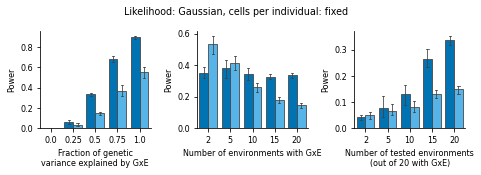

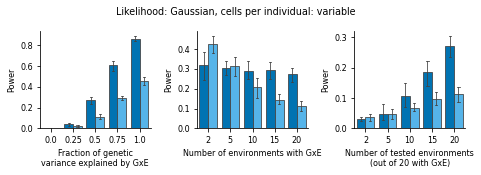

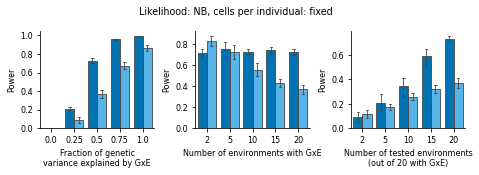

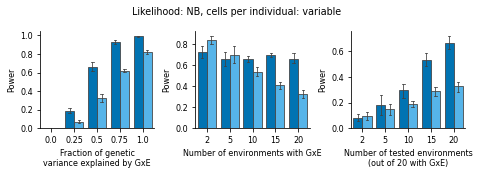

In [10]:
ll_names = {'negbin': 'NB', 'gaussian': 'Gaussian'}

for ll, cpi in product(likelihood, cells_per_individual):
    sub_df = params.query('n_snps == 1 and likelihood == @ll and cells_per_individual == @cpi')
   
    fig, axes = plt.subplots(1, 3, figsize=(3 * 2.2, 1.5 * 1.6))

    ax = axes[0]
    sns.barplot(
        x='r0', y='TPR', hue='model', 
        capsize=.1, errwidth=.8, saturation=1, palette=model_colors, edgecolor='.26', errcolor='.26', linewidth=.8,
        data=sub_df.query('n_env_gxe == 20 and n_env_tested == 20'), ax=ax)
    ax.set(
        xlabel='Fraction of genetic\nvariance explained by GxE',
        ylabel='Power')
    ax.get_legend().remove()

    ax = axes[1]
    sns.barplot(
        x='n_env_gxe', y='TPR', hue='model', 
        capsize=.1, errwidth=.8, saturation=1, palette=model_colors, edgecolor='.26', errcolor='.26', linewidth=.8,
        data=sub_df.query('r0 == 0.5 and n_env_tested == 20'), ax=ax)
    ax.set(
        xlabel='Number of environments with GxE',
        ylabel='Power')
    ax.get_legend().remove()

    ax = axes[2]
    sns.barplot(
        x='n_env_tested', y='TPR', hue='model', 
        capsize=.1, errwidth=.8, saturation=1, palette=model_colors, edgecolor='.26', errcolor='.26', linewidth=.8,
        data=sub_df.query('r0 == 0.5 and n_env_gxe == 20'), ax=ax)
    ax.set(
        xlabel='Number of tested environments\n(out of 20 with GxE)',
        ylabel='Power')
    ax.get_legend().remove()

    fig.suptitle('Likelihood: %s, cells per individual: %s' % (ll_names[ll], cpi))
    plt.tight_layout()
    sns.despine()
    
    plt.savefig('plots/power_%s_%s.svg' % (ll, cpi))